# 딥러닝 기말프로젝트

In [1]:
# Google drive mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR
from torch.optim import lr_scheduler

# dataset and transformation
import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
from PIL import Image

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy
from tqdm.notebook import tqdm

In [19]:
# data load
train_dir = os.path.join("/content/drive/MyDrive/Colab Notebooks/DeepLearning_6024/train")

# class path 
train_rock_dir = os.path.join(train_dir, "rock_summary")
train_scissors_dir = os.path.join(train_dir, "scissors_summary")
train_paper_dir = os.path.join(train_dir, "paper_summary")

In [20]:
train_rock_file = os.listdir(train_rock_dir)
train_scissors_file = os.listdir(train_scissors_dir)
train_paper_file = os.listdir(train_paper_dir)
print('# of rock images:', len(train_rock_file))
print('# of scissors images:', len(train_scissors_file))
print('# of paper images:', len(train_paper_file))

# of rock images: 1026
# of scissors images: 1020
# of paper images: 1026


In [45]:
# load image folder & data
transform = {
    'train': transforms.Compose([
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                               ]),
    'val': transforms.Compose([
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                               ])
}
# train_image_dataset = datasets.ImageFolder(train_dir, transform=transform, target_transform=None)
# train_loader = DataLoader(train_image_dataset, batch_size=32, shuffle=True, num_workers=2,) # drop_last=True

train_image_dataset = {x: datasets.ImageFolder(train_dir, transform=transform[x]) for x in ['train', 'val']}
data_loader = {x: torch.utils.data.DataLoader(
    train_image_dataset[x], batch_size=32, shuffle=True, num_workers=2, drop_last=True) for x in ['train', 'val']}
dataset_sizes = {x: len(train_image_dataset[x]) for x in ['train', 'val']}

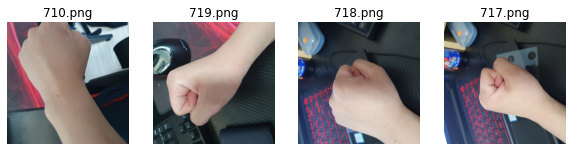

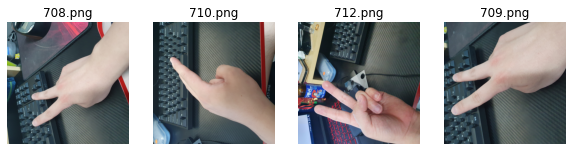

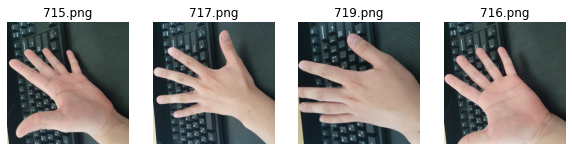

In [21]:
# show image
train_rock_image = [os.path.join(train_rock_dir, fname)
                   for fname in train_rock_file]
train_scissors_image = [os.path.join(train_scissors_dir, fname)
                   for fname in train_scissors_file]
train_paper_image = [os.path.join(train_paper_dir, fname)
                   for fname in train_paper_file]

def show_image(nrows, ncols, data_path):
    plt.figure(figsize=(10,10))
    for i in range(nrows*ncols):
        plt.subplot(nrows,ncols,i+1)
        plt.imshow(Image.open(data_path[i]))
        plt.title(data_path[i].split('/')[-1])
        plt.axis('off')
    plt.show()

nrows, ncols = 1, 4
show_image(nrows, ncols, train_rock_image)
show_image(nrows, ncols, train_scissors_image)
show_image(nrows, ncols, train_paper_image )

In [8]:
# setting "gpu" device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
new_model = CNN().to(device)

cuda:0


### VGG16

In [7]:
# load vgg16
base_model = models.vgg16(pretrained=False)

# create fully connected model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.feature = nn.Sequential(*list(resnet.children())[0:-1][0])
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc_layer = nn.Sequential(
            nn.Linear(512,100), nn.ReLU(),
            nn.Linear(100,3)
        )
    def forward(self, x):
        out = self.feature(x)
        out = self.gap(out)
        out = torch.squeeze(out)
        out = self.fc_layer(out)
        return out

In [9]:
for params in new_model.feature.parameters():
    params.require_grad = False
for params in new_model.fc_layer.parameters():
    params.requires_grad = True
    
summary(new_model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [10]:
# set loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(new_model.parameters(), lr=lr)

In [14]:
# model training
loss_list = []

for i in tqdm(range(num_epoch)):
    for j, [image, label] in enumerate(train_loader):
        x = image.to(device)
        y = label.to(device)
        
        optimizer.zero_grad()
        output = new_model.forward(x)
        loss = loss_func(output, y)
        loss.backward()
        optimizer.step()
        
    print(loss)
    loss_list.append(loss)

  0%|          | 0/10 [00:00<?, ?it/s]

tensor(1.0908, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0875, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1024, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0836, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0936, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0886, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1213, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1347, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0993, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0918, device='cuda:0', grad_fn=<NllLossBackward0>)


### ResNet101

In [26]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    # since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict()) # 그냥가져오면 reference가 되므로 복제
    best_acc = 0.0
    for epoch in tqdm(range(num_epochs)):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in data_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
            # zero the parameter gradients
                optimizer.zero_grad()
            # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
            # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
            # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model  # early stopping
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    # time_elapsed = time.time() - since
    # print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/DeepLearning_6024")

    return model

In [ ]:
torch.save()

In [28]:
# hyperparameter
lr =  1e-2
batch_size = 32
num_epoch = 30

In [46]:
# 끝단만 학습하는 transfer learning 적용
model_conv = models.resnet101(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False # 그레이디언트 계산을 하지 않기 때문에 파라미터 업데이트해도 달라지지 않음

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 3) # 맨 끝부분만 unfreeze

model_conv = model_conv.to(device)

## Loss function
criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=lr)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=3, gamma=0.1)

In [32]:
from torchsummary import summary

summary(model_conv, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [47]:
model_ft = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=num_epoch)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0/29
----------


KeyboardInterrupt: ignored

### Predict

In [ ]:
# load test data
test_dir = "******************************"
test_images = ImageFolder(test_dir, transform=transform, target_transform=None)
test_loader = DataLoader(test_images,
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers=0)

In [ ]:
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        output = model_conv.forward(x)
        _, output_index = torch.max(output, 1)
        if (output==0) # 주먹
        print()
